# Logistic Regression

Voorbeelden en oefeningen met classificatie ML-vraagstukken en validatie metrieken.

- Credit score

#### Bronmateriaal
- Heaton, Jeff. [Binary Classification: Understanding AUC, ROC, Precision/Recall & Sensitivity/Specificity](https://www.youtube.com/watch?v=oT2KFUxlclA)
- Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow*. O’Reilly Media.

In [1]:
%matplotlib inline

import os
import pandas as pd 
import numpy as np

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn import metrics 
from sklearn.metrics import accuracy_score 

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# software engineering
from pathlib import Path

# Increase font size for plots
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Create the `images/classification` folder
IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# helper function: load CSV data
import os
def load_csv_pd_data(path, filename):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel CSV-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    # DEBUG: print(xls_path)
    return pd.read_csv(csv_path)


---

## Credits classification

Dataset: `german_credit.csv`

Dataset bevat diverse waarnemingen en een kolom, waarin aangegeven is of het een slechte dan wel goede credit was geweest.

**ML-vraagstuk**: kan je van een klant voorspellen of het goede of slechte crediet wordt. Bedenk dat 'voorspellen' hier betekent 'classificeren'. 

In [3]:
# import dataset
# load the dataset using a helper function 
credit = load_csv_pd_data("./data", "german_credit.csv")
credit.head()

,Customer_ID,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1


In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Customer_ID               1000 non-null   int64 
 1   checking_account_status   1000 non-null   object
 2   loan_duration_mo          1000 non-null   int64 
 3   credit_history            1000 non-null   object
 4   purpose                   1000 non-null   object
 5   loan_amount               1000 non-null   int64 
 6   savings_account_balance   1000 non-null   object
 7   time_employed_yrs         1000 non-null   object
 8   payment_pcnt_income       1000 non-null   int64 
 9   gender_status             1000 non-null   object
 10  other_signators           1000 non-null   object
 11  time_in_residence         1000 non-null   int64 
 12  property                  1000 non-null   object
 13  age_yrs                   1000 non-null   int64 
 14  other_credit_outstanding 

### Data partitioning

Doel van dit voorbeeld is of op basis van de gegevens wel of niet een goede krediet is gegeven. Dit is een klassificatie probleem: wel of niet goede krediet.

Gevolg is dat een klassificatie model gebruikt wordt, in dit geval een Logistic Regression ML-model.

In [5]:
# number of good or bad credits...
# Dus dataset Y wordt het label dat we proberen te trainen
Y = credit['bad_credit']
Y.value_counts()

bad_credit
0    700
1    300
Name: count, dtype: int64

In [6]:
# replace categorical data with numeric values (one-hot-encoding)
# remark: the original credit dataframe is overwritten!
credit=pd.get_dummies(credit)
credit.head()

,Customer_ID,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit,checking_account_status_0 - 200 DM,...,home_ownership_own,home_ownership_rent,job_category_highly skilled,job_category_skilled,job_category_unemployed-unskilled-non-resident,job_category_unskilled-resident,telephone_none,telephone_yes,foreign_worker_no,foreign_worker_yes
0,1122334,6,1169,4,4,67,2,1,0,False,...,True,False,False,True,False,False,False,True,False,True
1,6156361,48,5951,2,2,22,1,1,1,True,...,True,False,False,True,False,False,True,False,False,True
2,2051359,12,2096,2,3,49,1,2,0,False,...,True,False,False,False,False,True,True,False,False,True
3,8740590,42,7882,2,4,45,1,2,0,False,...,False,False,False,True,False,False,True,False,False,True
4,3924540,24,4870,3,4,53,2,2,1,False,...,False,False,False,True,False,False,True,False,False,True


Wat doet pd.get_dummies()?

Categorische kolommen detecteren:
- Het detecteert automatisch de kolommen met categorische of object-datatypen in de credit DataFrame.

Nieuwe kolommen genereren:
- Voor elke unieke waarde in de categorische kolommen wordt een nieuwe kolom gemaakt. 
- Bijvoorbeeld, een kolom Gender met waarden ["Male", "Female"] wordt omgezet in twee kolommen:
            Gender_Male (1 als de rij "Male" is, anders 0)
            Gender_Female (1 als de rij "Female" is, anders 0).

Originele kolommen verwijderen:
- De originele categorische kolommen worden vervangen door de nieuwe dummy-kolommen.

Voorbeeld: Stel dat de oorspronkelijke credit DataFrame er als volgt uitziet:
- ID	Gender	Age	Status
- 1	Male	25	Single
- 2	Female	30	Married

Na pd.get_dummies(credit):
- ID	Age	Gender_Female	Gender_Male	Status_Married	Status_Single
- 1	25	0	1	0	1
- 2	30	1	0	1	0



In [7]:
# column names <-> feature names
# DUS kijk even wat get_dummies heeft gedaan; allemaal nieuwe kolommen
credit.columns

Index(['Customer_ID', 'loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
       'time_in_residence', 'age_yrs', 'number_loans', 'dependents',
       'bad_credit', 'checking_account_status_0 - 200 DM',
       'checking_account_status_< 0 DM',
       'checking_account_status_> 200 DM or salary assignment',
       'checking_account_status_none', 'credit_history_all loans at bank paid',
       'credit_history_critical account - other non-bank loans',
       'credit_history_current loans paid', 'credit_history_no credit - paid',
       'credit_history_past payment delays', 'purpose_business',
       'purpose_car (new)', 'purpose_car (used)',
       'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_other',
       'purpose_radio/television', 'purpose_repairs', 'purpose_retraining',
       'savings_account_balance_100 - 500 DM',
       'savings_account_balance_500 - 1000 DM',
       'savings_account_balance_< 100 DM',
       'savings_acco

In [8]:
# construct features ...
X=credit[
    ['loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
       'time_in_residence', 'age_yrs', 'number_loans', 'dependents',
       'checking_account_status_0 - 200 DM',
       'checking_account_status_< 0 DM',
       'checking_account_status_> 200 DM or salary assignment',
       'checking_account_status_none', 'credit_history_all loans at bank paid',
       'credit_history_critical account - other non-bank loans',
       'credit_history_current loans paid', 'credit_history_no credit - paid',
       'credit_history_past payment delays', 'purpose_business',
       'purpose_car (new)', 'purpose_car (used)',
       'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_other',
       'purpose_radio/television', 'purpose_repairs', 'purpose_retraining',
       'savings_account_balance_100 - 500 DM',
       'savings_account_balance_500 - 1000 DM',
       'savings_account_balance_< 100 DM',
       'savings_account_balance_>= 1000 DM',
       'savings_account_balance_unknown/none', 'time_employed_yrs_1 - 4 years',
       'time_employed_yrs_4 - 7 years', 'time_employed_yrs_< 1 year',
       'time_employed_yrs_>= 7 years', 'time_employed_yrs_unemployed',
       'gender_status_female-divorced/separated/married',
       'gender_status_male-divorced/separated',
       'gender_status_male-married/widowed', 'gender_status_male-single',
       'other_signators_co-applicant', 'other_signators_guarantor',
       'other_signators_none',
       'property_building society savings/life insurance',
       'property_car or other', 'property_real estate',
       'property_unknown-none', 'other_credit_outstanding_bank',
       'other_credit_outstanding_none', 'other_credit_outstanding_stores',
       'home_ownership_for free', 'home_ownership_own', 'home_ownership_rent',
       'job_category_highly skilled', 'job_category_skilled',
       'job_category_unemployed-unskilled-non-resident',
       'job_category_unskilled-resident', 'telephone_none', 'telephone_yes',
       'foreign_worker_no', 'foreign_worker_yes'
    ]
]

In [9]:
# train/test split datasets...
# DUS dataset X bevat alle features
# dataset Y bevat een 0 of 1 (1 betekent "bad credit")
# test_size=0.3: 30% van de data wordt toegewezen aan de testset, terwijl de resterende 70% wordt gebruikt voor training.
# random_state=42: Zorgt voor reproduceerbare splitsing van de data. Bij hetzelfde random seed krijg je altijd dezelfde splitsing.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [10]:
X_train.head()  # see original values

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,checking_account_status_0 - 200 DM,checking_account_status_< 0 DM,checking_account_status_> 200 DM or salary assignment,...,home_ownership_own,home_ownership_rent,job_category_highly skilled,job_category_skilled,job_category_unemployed-unskilled-non-resident,job_category_unskilled-resident,telephone_none,telephone_yes,foreign_worker_no,foreign_worker_yes
541,48,7763,4,4,42,1,1,False,True,False,...,False,False,True,False,False,False,True,False,False,True
440,24,1287,4,4,37,2,1,False,False,False,...,True,False,False,True,False,False,False,True,False,True
482,15,1478,4,4,44,2,2,False,True,False,...,True,False,False,True,False,False,False,True,False,True
422,18,1042,4,2,33,1,1,True,False,False,...,True,False,False,True,False,False,True,False,False,True
778,36,5711,4,2,38,2,1,False,False,False,...,True,False,True,False,False,False,False,True,False,True


### Preprocessing - scale feature values

In [11]:
# scaling is a very common activity to get the values in "same" range.
# most ML-models like that
scaler=MinMaxScaler()

X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

Maar even stap voor stap wat gebeurt er nu boven?

Min-Max Scaler initialiseren:

    scaler = MinMaxScaler() initialiseert de scaler, die standaard de waarden schaalt naar het bereik [0,1][0,1]. Dit betekent dat de kleinste waarde in een kenmerk naar 0 wordt geschaald en de grootste waarde naar 1.

Fit en transformatie toepassen op X_train:

    scaler.fit_transform(X_train) leert de minimum- en maximumwaarden van elk kenmerk in de trainingsset (met fit) en schaalt vervolgens de waarden (met transform). Dit zorgt ervoor dat de schaalinformatie alleen van de trainingsdata komt, om data leakage te voorkomen.

Transformatie toepassen op X_test:

    scaler.transform(X_test) schaalt de testset met dezelfde minimum- en maximumwaarden die op de trainingsset zijn geleerd. Hierdoor blijft de testset consistent met de trainingsset.

DataFrame herstructureren:

    Omdat MinMaxScaler een numpy-array retourneert, wordt de output teruggezet in een pandas DataFrame met dezelfde kolomnamen als de oorspronkelijke X_train en X_test:

In [12]:
X_train.head()

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,checking_account_status_0 - 200 DM,checking_account_status_< 0 DM,checking_account_status_> 200 DM or salary assignment,...,home_ownership_own,home_ownership_rent,job_category_highly skilled,job_category_skilled,job_category_unemployed-unskilled-non-resident,job_category_unskilled-resident,telephone_none,telephone_yes,foreign_worker_no,foreign_worker_yes
0,0.647059,0.413393,1.0,1.000000,0.410714,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.294118,0.057060,1.0,1.000000,0.321429,0.333333,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.161765,0.067569,1.0,1.000000,0.446429,0.333333,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.205882,0.043579,1.0,0.333333,0.250000,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.470588,0.300484,1.0,0.333333,0.339286,0.333333,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Train the logistic regression model

In [13]:
# EN DAN EINDELIJK gaan we trainen ;-)
logreg = LogisticRegression()
# train het model op dataset X_train (features) en Y_train (labels)
mod1 = logreg.fit(X_train, Y_train)

### Plot the weights for each feature

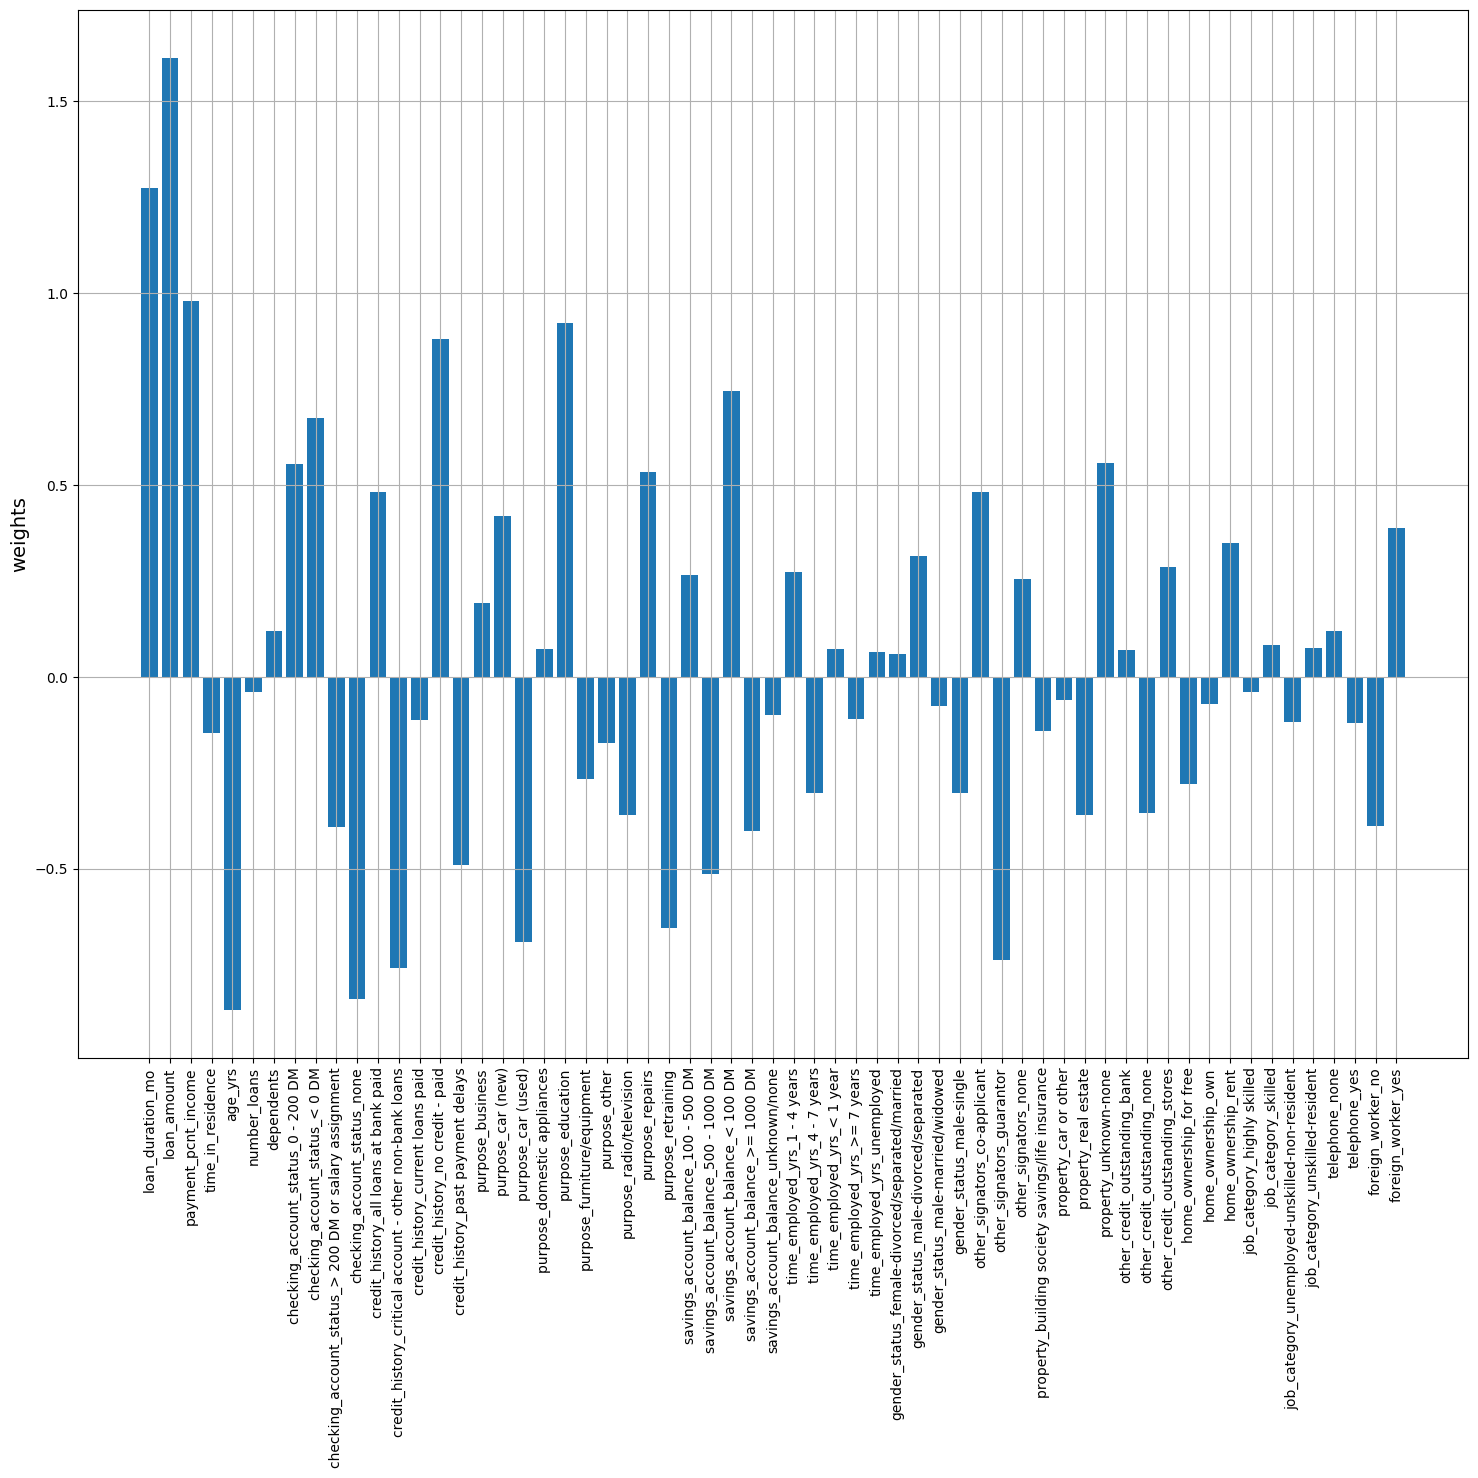

In [14]:
# Visualiseer gewichten (coëfficiënten) van het getrainde logistieke regressiemodel (logreg) met behulp van een staafdiagram. 
plt.figure(figsize=(15, 15))

plt.ylabel("weights")
plt.grid()

plt.bar(X_train.columns.tolist(),logreg.coef_[0])
plt.xticks(rotation=90,size=10)

save_fig("logistic_regression.png")
plt.show()

